In [52]:
import matplotlib.pyplot as plt
import mlb as mlb
import numpy as np

plt.style.use("ggplot")


In [53]:
# ---- helper functions -------------------------------------------------
def kl(p, q):  # binary kl
    p = np.clip(p, 1e-12, 1 - 1e-12)
    q = np.clip(q, 1e-12, 1 - 1e-12)
    return p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))


def kl_inverse_upper(p_hat, eps, tol=1e-12, max_iter=60):
    """
    smallest q >= p_hat such that kl(p_hat‖q) > eps
    (so the returned value is an upper confidence bound on the true p)
    """
    if eps == 0:  # no slack
        return p_hat

    lo, hi = p_hat, 1.0 - 1e-12  # KL is monotone ↑ in q on [p_hat , 1)
    for _ in range(max_iter):
        mid = (lo + hi) / 2
        if kl(p_hat, mid) > eps:  # mid is still outside the admissible set
            hi = mid  # move the upper edge down
        else:  # mid is admissible
            lo = mid  # move the lower edge up
        if hi - lo < tol:
            break
    return hi  # any point in (lo , hi] is ok; we return hi


In [ ]:
# ---- parameters -------------------------------------------------------
n, delta = 100, 0.05
p12_grid = np.linspace(0, 1, 101)

k = np.ceil(np.log2(np.sqrt(n / np.log(1 / delta)) / 2))

Lambda = 0.5 * np.power(0.5, np.arange(k))  # {1/2,1/4,...}

print(k)
print(Lambda)

UB_vals, KL_vals, p_vals, phats, vhats = [], [], [], [], []

for p12 in p12_grid:
    p0 = p1 = (1.0 - p12) / 2.0
    # sample
    z = np.random.choice([0, 0.5, 1], size=n, p=[p0, p12, p1])
    phat = z.mean()
    vhat = (z**2).mean()
    p_vals.append(0.5 - phat)
    vhats.append(vhat)
    phats.append(phat)

    # UB bound
    ub_list = [lam * vhat + np.log(Lambda / delta) / (lam * n) for lam in Lambda]
    UB_vals.append(np.min(ub_list))

    # kl bound
    eps = (np.log((n + 1.0) / delta)) / n
    KL_vals.append(kl_inverse_upper(phat, eps) - phat)


2.0
[0.5  0.25]


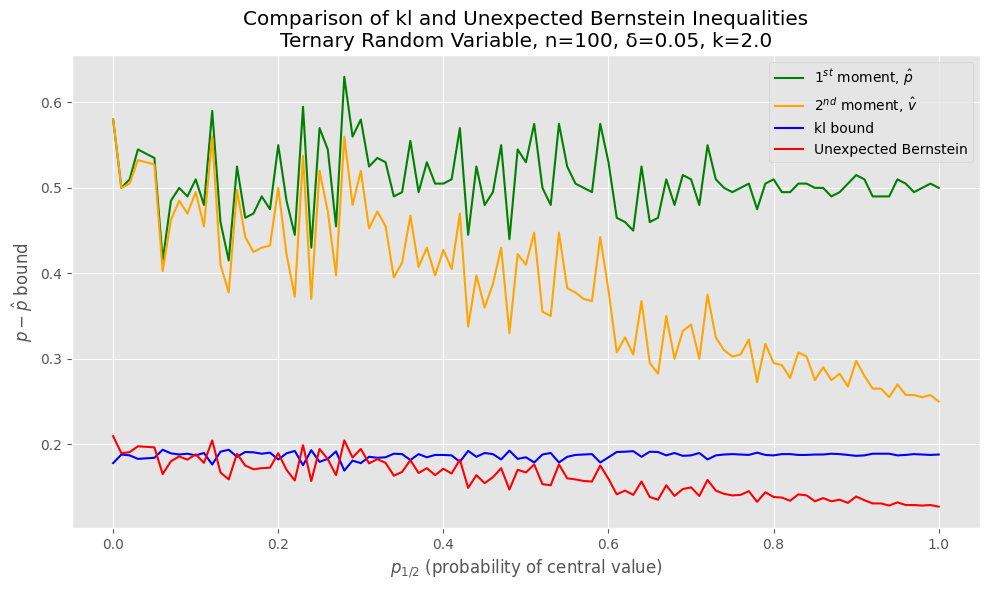

In [55]:
plt.figure(figsize=(10, 6))
# plt.plot(p12_grid, p_vals, "g-", label="Realized $p - \hat p$")
plt.plot(p12_grid, phats, color="green", label="$1^{st}$ moment, $\hat p$")
plt.plot(p12_grid, vhats, color="orange", label="$2^{nd}$ moment, $\hat v$")
plt.plot(p12_grid, KL_vals, "b-", label="kl bound")
plt.plot(p12_grid, UB_vals, "r-", label="Unexpected Bernstein")
plt.xlabel(r"$p_{1/2}$ (probability of central value)")
plt.ylabel(r"$p-\hat p$ bound")
plt.legend()
plt.title(
    "Comparison of kl and Unexpected Bernstein Inequalities\n"
    + f"Ternary Random Variable, n={n}, δ={delta}, k={k}"
)
plt.tight_layout()
plt.savefig("kl_vs_bernstein_bounds.pdf", dpi=600, bbox_inches="tight")
plt.show()